In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
# from data_loader import Dataset as SopeDataset  # your existing SOPE loader
import cutoop
from cutoop.data_loader import Dataset as SopeDataset

from cutoop.data_loader import Dataset as SopeDataset

# root = Path("/home/mirshad7/Downloads/data/Omni6DPose/SOPE")

root = Path("/home/mirshad7/Downloads/data/Omni6DPose/SOPE")

# Grab a few prefixes
prefixes = SopeDataset.glob_prefix(str(root))
print(f"Found {len(prefixes)} frames.")
print("Example prefix:", prefixes[10])



Found 367786 frames.
Example prefix: /home/mirshad7/Downloads/data/Omni6DPose/SOPE/39/train/matterport3d/0147/0023_


In [2]:
print("Example prefix:", prefixes[65000])

Example prefix: /home/mirshad7/Downloads/data/Omni6DPose/SOPE/38/train/matterport3d/0029/0001_


In [20]:
idx = 65000  # change to any index
# prefix = prefixes[idx]

prefix = '/home/mirshad7/Downloads/data/Omni6DPose/SOPE/39/train/matterport3d/0147/0014_'

color = SopeDataset.load_color(prefix + "color.png")
depth = SopeDataset.load_depth(prefix + "depth.exr")
mask  = SopeDataset.load_mask(prefix + "mask.exr")
meta  = SopeDataset.load_meta(prefix + "meta.json")

print(f"Color shape: {color.shape}, dtype: {color.dtype}")
print(f"Depth shape: {depth.shape}, range: [{depth.min():.3f}, {depth.max():.3f}]")
print(f"Mask unique IDs: {np.unique(mask)}")
print(f"Num objects in meta: {len(meta.objects)}")


Color shape: (512, 640, 3), dtype: uint8
Depth shape: (512, 640), range: [0.000, 9.833]
Mask unique IDs: [ 0  1  2  5  6  7  8  9 12 13 14 15 18 19 20 21 22 23 25 28]
Num objects in meta: 19


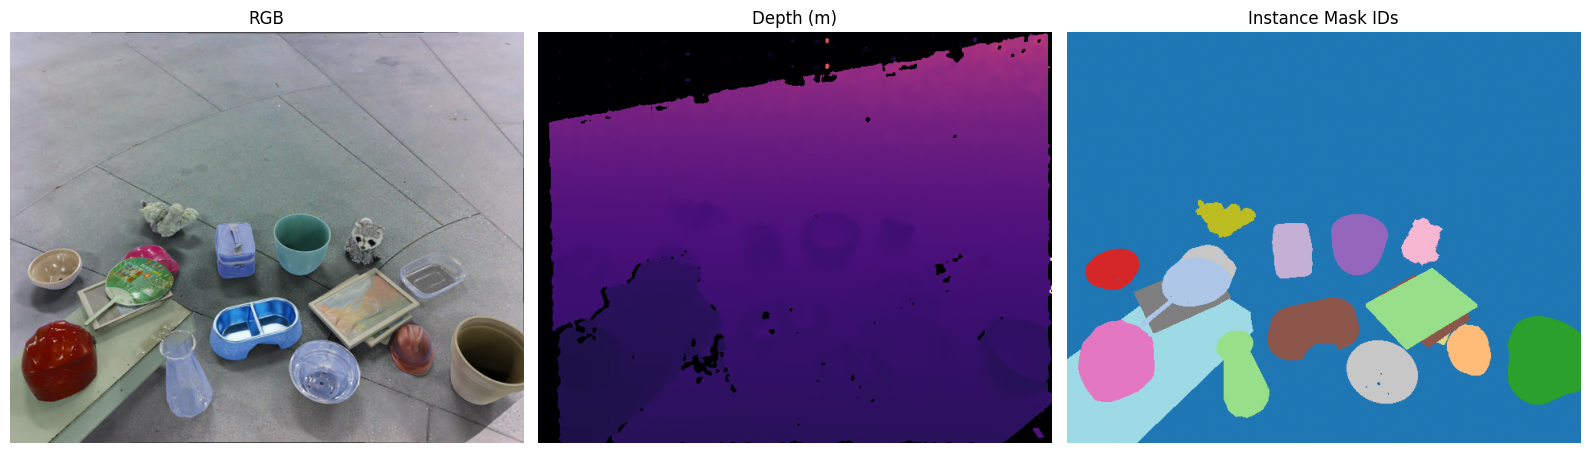

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(color)
axs[0].set_title("RGB")

axs[1].imshow(depth, cmap='magma')
axs[1].set_title("Depth (m)")

axs[2].imshow(mask, cmap='tab20')
axs[2].set_title("Instance Mask IDs")

for a in axs:
    a.axis('off')
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
from cutoop.rotation import SymLabel

# Constant rotations (right-handed, active)
rot90 = {
    "x": np.array([[1,0,0],[0,0,-1],[0,1,0]], dtype=float),
    "y": np.array([[0,0,1],[0,1,0],[-1,0,0]], dtype=float),
    "z": np.array([[0,-1,0],[1,0,0],[0,0,1]], dtype=float),
}
rot180 = {
    "x": np.diag([ 1,-1,-1]).astype(float),
    "y": np.diag([-1, 1,-1]).astype(float),
    "z": np.diag([-1,-1, 1]).astype(float),
}

def angle_to_identity(R: np.ndarray) -> float:
    # theta = arccos((trace(R) - 1)/2)
    val = (np.trace(R) - 1.0) * 0.5
    val = np.clip(val, -1.0, 1.0)
    return float(np.arccos(val))

def _canon_any_about_axis(R: np.ndarray, axis: str) -> np.ndarray:
    # Remove rotation about the given axis analytically
    if axis == "z":
        phi = np.arctan2(R[1,0], R[0,0])
        c, s = np.cos(-phi), np.sin(-phi)
        Rz = np.array([[c,-s,0],[s,c,0],[0,0,1]], dtype=float)
        return R @ Rz
    if axis == "y":
        phi = np.arctan2(R[0,2], R[2,2])
        c, s = np.cos(-phi), np.sin(-phi)
        Ry = np.array([[c,0,s],[0,1,0],[-s,0,c]], dtype=float)
        return R @ Ry
    if axis == "x":
        phi = np.arctan2(R[2,1], R[1,1])
        c, s = np.cos(-phi), np.sin(-phi)
        Rx = np.array([[1,0,0],[0,c,-s],[0,s,c]], dtype=float)
        return R @ Rx
    raise ValueError(f"unknown axis: {axis}")

def canonicalize_rotation_subset(R: np.ndarray, sym) -> np.ndarray:
    """
    Analytic canonicalization for the subset:
      - 'none'
      - '*-flip'   (180°)
      - '*-quarter' (90° multiples)  ← if you use x/y/z-square-pyramid
      - '*-cone' or '*-any' (arbitrary-angle about axis)
      - 'box' (180° about each of x,y,z)
    Accepts sym as str or SymLabel.
    Returns a 3x3 rotation matrix R* equivalent to R under that symmetry,
    chosen to be closest to identity.
    """
    # normalize to string name
    if isinstance(sym, SymLabel):
        sym_name = str(sym)
    elif isinstance(sym, str):
        sym_name = sym
    else:
        raise TypeError(f"Expected str or SymLabel, got {type(sym)}")

    if sym_name == "none":
        return R.copy()

    # Handle "box" (half on all three axes): choose among I, Rx180, Ry180, Rz180
    if sym_name == "box":
        cand = [np.eye(3), rot180["x"], rot180["y"], rot180["z"]]
        bestR, bestθ = None, 1e9
        for C in cand:
            Rc = R @ C
            θ  = angle_to_identity(Rc)
            if θ < bestθ:
                bestR, bestθ = Rc, θ
        return bestR

    axis = sym_name[0]  # 'x','y','z'

    # 180° symmetry (flip)
    if sym_name.endswith("flip"):
        R1 = R @ rot180[axis]
        return R if angle_to_identity(R) <= angle_to_identity(R1) else R1

    # 90° symmetry (quarter): e.g., x-square-pyramid / y-square-pyramid / z-square-pyramid
    if sym_name.endswith("quarter") or sym_name.endswith("square-pyramid"):
        bestR, bestθ = R, angle_to_identity(R)
        Rk = R.copy()
        for _ in range(3):
            Rk = Rk @ rot90[axis]
            θ  = angle_to_identity(Rk)
            if θ < bestθ:
                bestR, bestθ = Rk.copy(), θ
        return bestR

    # Arbitrary-angle symmetry about axis (cone/any)
    if sym_name.endswith("any") or sym_name.endswith("cone"):
        return _canon_any_about_axis(R, axis)

    # (Optional) If you ever see square-tube/cylinder and want to keep subset strict,
    # you can decide to map them to the closest supported case or raise:
    # - square-tube = quarter about axis + half about other two axes (finite set)
    # - cylinder    = any about axis + half about two perpendicular axes
    # For now, since your subset excludes them, raise:
    raise ValueError(f"unsupported symmetry for this subset: {sym_name}")



obj.meta ObjectMetaInfo(oid='google_scan-dish_0085', class_name='dish', class_label=37, instance_path='data/object_meshes/google_scan-dish_0085/Aligned.obj', scale=[0.0009409084110570753, 0.0009409084110570753, 0.0009409084110570753], is_background=False, bbox_side_len=[0.3466968238353729, 0.063565194606781, 0.21007157862186432])
Object symmetry: y-cone
obj.meta ObjectMetaInfo(oid='omniobject3d-fan_008', class_name='fan', class_label=48, instance_path='data/object_meshes/omniobject3d-fan_008/Aligned.obj', scale=[0.0011051171834356903, 0.0011051171834356903, 0.0011051171834356903], is_background=False, bbox_side_len=[0.3627261817455292, 0.013489218428730965, 0.2649151384830475])
Object symmetry: x-flip
obj.meta ObjectMetaInfo(oid='omniobject3d-helmet_007', class_name='helmet', class_label=68, instance_path='data/object_meshes/omniobject3d-helmet_007/Aligned.obj', scale=[0.000774091577548582, 0.000774091577548582, 0.000774091577548582], is_background=False, bbox_side_len=[0.2291607260704

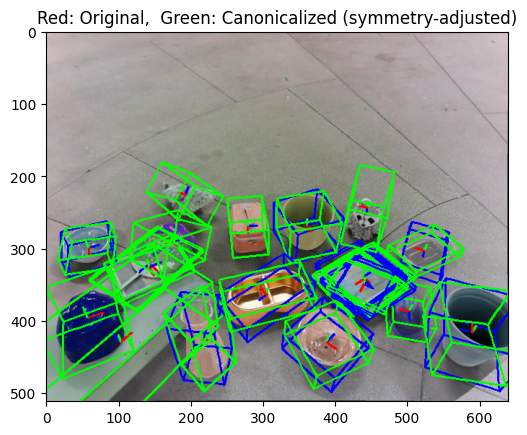

In [ ]:

from cutoop.utils import draw_3d_bbox, draw_pose_axes
from cutoop.data_types import Pose
import cv2

intrinsics = meta.camera.intrinsics

vis_img = color.copy()
vis_img_2 = color.copy()

objmeta = cutoop.obj_meta.ObjectMetaData.load_json(
    "/home/mirshad7/Downloads/data/Omni6DPose/Meta/obj_meta.json"
)

for obj in meta.objects:
    R_gt = Pose(tuple(obj.quaternion_wxyz), tuple(obj.translation)).to_affine()[:3,:3]
    T = Pose(tuple(obj.quaternion_wxyz), tuple(obj.translation)).to_affine()
    size = np.array(obj.meta.bbox_side_len)

    print("obj.meta", obj.meta)

    objinfo = objmeta.instance_dict[obj.meta.oid]

    # --- (1) Draw original ---
    vis_img_2 = draw_3d_bbox(vis_img_2, intrinsics, sRT_4x4=T, bbox_side_len=size)
    vis_img_2 = draw_pose_axes(vis_img_2, intrinsics, sRT_4x4=T, length=0.1)

    # # --- (2) Canonicalize ---
    # sym_name = getattr(obj.meta, "symmetry", "none")  # must be set in meta
    sym_name = objinfo.tag.symmetry
    print("Object symmetry:", sym_name)
    R_star = canonicalize_rotation_subset(R_gt, sym_name)
    T_star = T.copy()
    T_star[:3,:3] = R_star

    print("original R:\n", R_gt)
    print("canonicalized R:\n", R_star)

    vis_img = draw_3d_bbox(vis_img, intrinsics, sRT_4x4=T_star, bbox_side_len=size, color =(255,0,0))
    vis_img = draw_pose_axes(vis_img, intrinsics, sRT_4x4=T_star, length=0.1)

    vis_img = draw_3d_bbox(vis_img, intrinsics, sRT_4x4=T, bbox_side_len=size, color =(0,255,0))

plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
plt.title("Red: Original,  Green: Canonicalized (symmetry-adjusted)")
plt.show()


# from cutoop.data_types import Pose

# for i, data in enumerate(meta.objects):
#     idx = tuple(np.argwhere(mask == data.mask_id).T)

#     bbox_side_len = data.meta.bbox_side_len
#     obj_pose = Pose(
#         quaternion=data.quaternion_wxyz, translation=data.translation
#     )

#     scale = data.meta.scale[0]

#     pose_mat = obj_pose.to_affine()
#     R = pose_mat[:3, :3]

#     R_gt = pose_mat[:3, :3]

#     rot6d_gt = R_gt[:, :2].reshape(-1)  # first two columns flattened → (6,)

#     a1 = rot6d_gt[:, 0]
#     a2 = rot6d_gt[:, 1]
#     b1 = a1 / (np.linalg.norm(a1) + 1e-8)
#     b2 = a2 - np.dot(b1, a2) * b1
#     b2 /= (np.linalg.norm(b2) + 1e-8)
#     b3 = np.cross(b1, b2)
#     R = np.stack((b1, b2, b3), axis=1)  # (3,3)

#     print("Orthogonalized Rotation:\n", R)
#     print("Original Rotation:\n", R_gt)
    
#     T = pose_mat[:3, 3]
#     print("actual object", i)
#     print(" Scale:", scale)
#     print(" Rotation:\n", R)
#     print(" Translation:\n", T)
#     print(" BBox side len:", bbox_side_len)
#     print("====================================\n\n")

img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, scale_y: 0.5 0.5
img shape before drawing: (512, 640, 3)
intrinsics.height, intrinsics.width: 1024 1280
scale_x, 

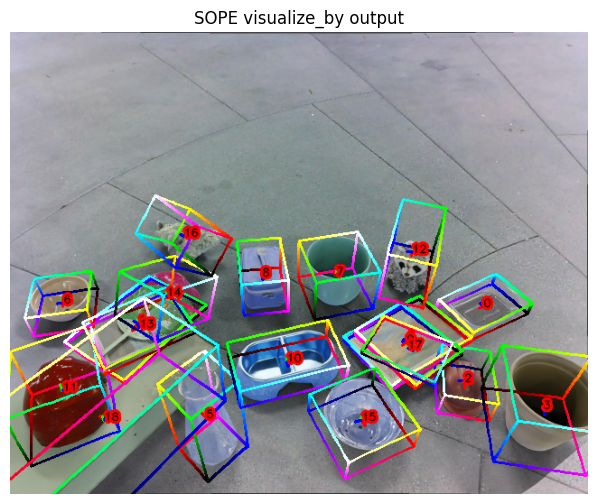

In [4]:
vis = SopeDataset.visualize_by(
    vis_img=color.copy(),
    prefix=prefix,
    show_id=True,
    show_box=True,
    show_axes_len=0.05
)

plt.figure(figsize=(8, 6))
plt.imshow(vis)
plt.title("SOPE visualize_by output")
plt.axis("off")
plt.show()


In [ ]:
# vis = SopeDataset.visualize_by(
#     vis_img=color.copy(),
#     prefix=prefix,
#     show_id=True,
#     show_box=True,
#     show_nocs_pred=True,
#     show_axes_len=0.05
# )

# plt.figure(figsize=(8, 6))
# plt.imshow(vis)
# plt.title("SOPE visualize_by output")
# plt.axis("off")
# plt.show()


In [ ]:
# for i, obj in enumerate(meta.objects):
#     print(f"--- Object {i} ---")
#     print(f"mask_id: {obj.mask_id}")
#     print(f"quaternion (wxyz): {obj.quaternion_wxyz}")
#     print(f"translation: {obj.translation}")
#     if hasattr(obj.meta, "bbox_side_len"):
#         print(f"bbox_side_len: {obj.meta.bbox_side_len}")
    
#     print()


len(heatmaps): 19
heatmaps[0] shape: (512, 640)
combined_heatmap shape: (512, 640)


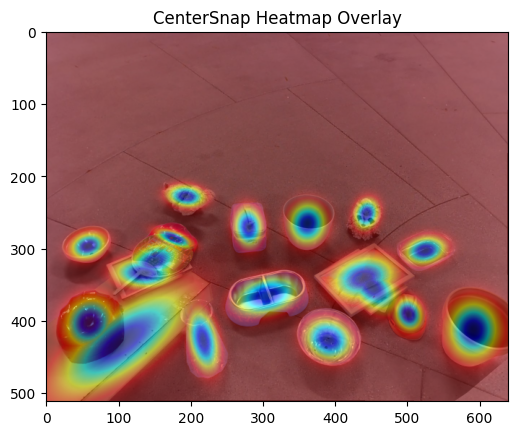

In [5]:
# from cutoop.centersnap_dataloader import compute_heatmaps_from_masks
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from preprocessing.utils import compute_heatmaps_from_masks



import cv2
mask_ids = np.unique(mask)[1:]
masks_list = [(mask == mid).astype(np.uint8) for mid in mask_ids]

intrinsics = meta.camera.intrinsics  # SOPE stores this in meta

heatmaps = compute_heatmaps_from_masks(masks_list, meta_objects=meta.objects, intrinsics=intrinsics)

print("len(heatmaps):", len(heatmaps))
print("heatmaps[0] shape:", heatmaps[0].shape)

# heatmaps = compute_heatmaps_from_masks(masks_list)
heatmap_peaks = np.max(np.stack(heatmaps, axis=0), axis=0)
print("combined_heatmap shape:", heatmap_peaks.shape)
combined_heatmap = np.clip(heatmap_peaks.copy(), 0.0, 1.0) * 255.0
combined_heatmap = cv2.applyColorMap(combined_heatmap.astype(np.uint8), cv2.COLORMAP_JET)

plt.imshow(color)
plt.imshow(combined_heatmap, alpha=0.5)
plt.title("CenterSnap Heatmap Overlay")
plt.show()


In [ ]:
print("combined_heatmap shape:", combined_heatmap.shape)
print("intrinsics", intrinsics)

In [9]:
print(intrinsics)
from cutoop.data_types import CameraIntrinsicsBase
# intrinsic_vis: CameraIntrinsicsBase(fx=538.6199951171875, fy=538.7349853515625, cx=322.1059875488281, cy=259.6960144042969, width=640, height=480)

intrinsics = CameraIntrinsicsBase(fx=538.6199951171875, fy=538.7349853515625, cx=322.1059875488281, cy=259.6960144042969, width=640, height=512)

from preprocessing.utils import compute_nocs_abspose_field
from cutoop.data_types import Pose

# from cutoop.centersnap_dataloader import compute_nocs_abspose_field

poses = [Pose(tuple(o.quaternion_wxyz), tuple(o.translation))
        for o in meta.objects]

bbox_side_lengths = [o.meta.bbox_side_len for o in meta.objects]

print("bbox_side_lengths", len(bbox_side_lengths))
print("bbox_side_lengths", bbox_side_lengths[0])

abs_pose_target = compute_nocs_abspose_field(poses, heatmaps, bbox_side_lengths)

print("abs_pose_target shape:", abs_pose_target.shape)


CameraIntrinsicsBase(fx=538.6199951171875, fy=538.7349853515625, cx=322.1059875488281, cy=259.6960144042969, width=640, height=480)
bbox_side_lengths 19
bbox_side_lengths [0.3466968238353729, 0.063565194606781, 0.21007157862186432]
abs_pose_target shape: (256, 320, 12)


heatmap_peaks (512, 640)
Detected peaks: (19, 2)
T [[ 0.22353423  0.02477193 -0.9743812  -1.0080765 ]
 [ 0.65318745 -0.7457979   0.1308881   0.15510297]
 [-0.7234491  -0.6657116  -0.18289205  2.0682755 ]
 [ 0.          0.          0.          1.        ]]
size [0.23436758 0.10736912 0.23385227]
T [[-0.43234852 -0.08786752  0.8974153  -0.67177856]
 [-0.43165275 -0.85362846 -0.29153806  0.35091805]
 [ 0.79167587 -0.51341784  0.33113673  1.3738626 ]
 [ 0.          0.          0.          1.        ]]
size [0.28804895 0.17545843 0.22554846]
T [[-0.8076978   0.02882173  0.58889186 -0.6260624 ]
 [-0.41338393 -0.739864   -0.5307683   0.49156928]
 [ 0.4204022  -0.6721388   0.60950094  1.55224   ]
 [ 0.          0.          0.          1.        ]]
size [0.35593027 0.32449535 0.703195  ]
T [[-0.82809603  0.03234785 -0.55965227 -0.5299375 ]
 [ 0.36780745 -0.7220543  -0.5859653   0.20121527]
 [-0.423054   -0.6910798   0.5860325   1.6000055 ]
 [ 0.          0.          0.          1.        ]]
siz

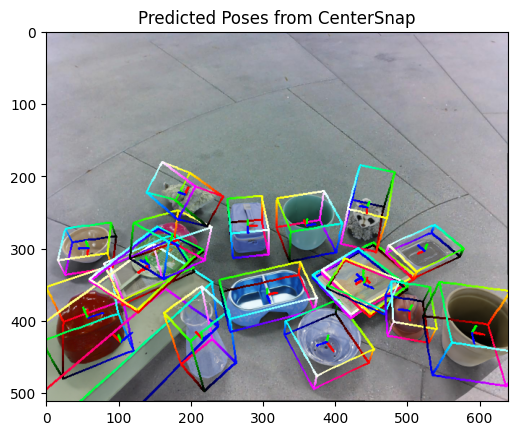

In [10]:
from training.data.datasets.utils import extract_peaks_from_centroid, extract_abs_pose_from_peaks, draw_peaks
from cutoop.data_types import CameraIntrinsicsBase
from functools import partial
from cutoop.utils import draw_3d_bbox, draw_pose_axes

peaks = extract_peaks_from_centroid(heatmap_peaks, min_distance=10, min_confidence=0.20)

heatmap_pred = draw_peaks(heatmap_peaks, peaks)

heatmap_vis = np.clip(heatmap_pred.copy(), 0.0, 1.0) * 255.0
heatmap_vis = cv2.applyColorMap(heatmap_vis.astype(np.uint8), cv2.COLORMAP_JET)


print("heatmap_peaks", heatmap_peaks.shape)
print("Detected peaks:", peaks.shape)
# Extract predicted absolute poses
abs_poses, sizes = extract_abs_pose_from_peaks(peaks, abs_pose_target, scale_factor=2)

#adjust intrinsics based on 

bbox_task = []
# Visualize predicted poses
for j, (T, size) in enumerate(zip(abs_poses, sizes)):
    print("T", T)
    print("size", size)
    bbox_task.append(
        partial(
            draw_3d_bbox,
            intrinsics=intrinsics,
            sRT_4x4=T,
            bbox_side_len=size,
        )
    )
    bbox_task.append(
        partial(
            draw_pose_axes,
            intrinsics=intrinsics,
            sRT_4x4=T,
            length=0.1,
        )
    )
print("len bbox_task", len(bbox_task))

vis_img = color.copy()
for filter in bbox_task:
    vis_img = filter(img=vis_img)

plt.imshow(vis_img)
plt.title("Predicted Poses from CenterSnap")
plt.show()

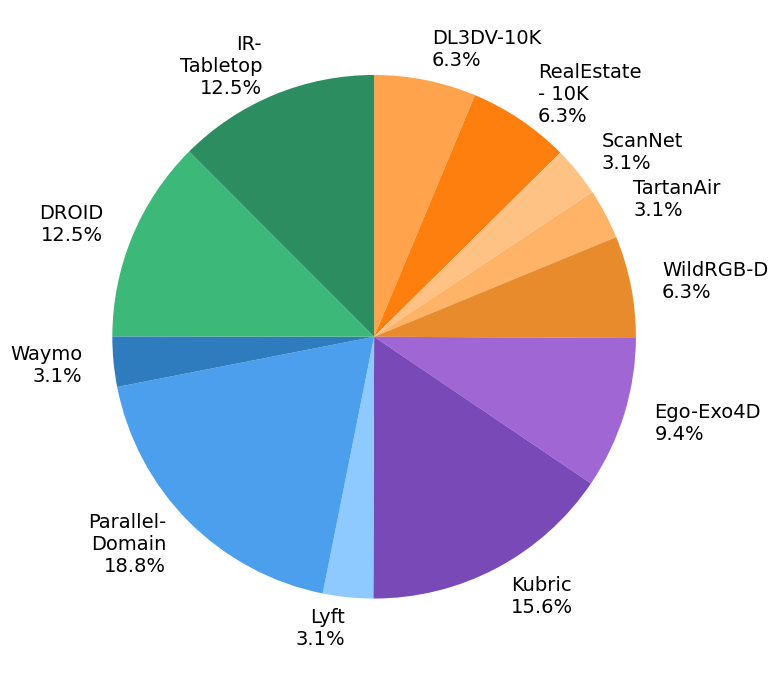

In [ ]:
# '''
# BVH, Updated by Zubair Nov 2025.
# cd ~/ws/repos/_my-priv-util/a4d2/misc
# python datapie.py
# '''

import matplotlib.pyplot as plt

# --- Data ---
benchmarks = [
    "DL3DV-10K", "RealEstate-10K", "ScanNet", "TartanAir", "WildRGB-D",
    "Ego-Exo4D", "Kubric",
    "Lyft", "ParallelDomain", "Waymo",
    "DROID", "IR-Tabletop"
]
domains = [
    "3D", "3D", "3D", "3D", "3D",
    "4D", "4D",
    "Driving", "Driving", "Driving",
    "Robotics", "Robotics"
]
weights = [0.063, 0.063, 0.031, 0.031, 0.063,
           0.094, 0.156,
           0.031, 0.188, 0.031,
           0.125, 0.125]

# --- Color mapping ---
color_map = {
    "Driving": ["#8EC9FF", "#4C9FEC", "#2E7BBE"],
    "Robotics": ["#3CB878", "#2C8E60"],
    "3D": ["#FFA34D", "#FF7F0E", "#FFC285", "#FFB366", "#E88B2D"],
    "4D": ["#A066D3", "#7A49B8"]
}

# Assign colors sequentially per domain
color_assignments = []
idx = {"Driving": 0, "Robotics": 0, "3D": 0, "4D": 0}
for d in domains:
    color_assignments.append(color_map[d][idx[d] % len(color_map[d])])
    idx[d] += 1

import textwrap
import matplotlib.patheffects as path_effects
def wrap_label(name, width=10):
    # Manual overrides for specific long names
    if name == "ParallelDomain":
        name = "Parallel-\nDomain"
    elif name == "RealEstate-10K":
        name = "RealEstate-\n10K"
    return "\n".join(textwrap.wrap(name, width))
labels = [f"{wrap_label(b)}\n{w*100:.1f}%" for b, w in zip(benchmarks, weights)]

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 8.5))
wedges, texts = ax.pie(
    weights,
    labels=labels,
    startangle=90,
    counterclock=False,
    colors=color_assignments,
    labeldistance=1.12,
    rotatelabels=False,
    textprops={'color': 'black', 'fontsize': 14}  # larger, no bold
)

plt.savefig("dataset_pie_labels_transparent.png",
            bbox_inches='tight', dpi=300, transparent=True)


plt.show()

